In [101]:
from utils.database_connection import DatabaseConnection
import utils.results_repository as rep
import pandas as pd
import numpy as np
from utils.column_name_utils import *
import utils.query_utils as query
import matplotlib.pyplot as plot
import utils.dataframe_utils as df_util
import utils.path_utils as path_util
import utils.latex_utils as tex

In [102]:
db = DatabaseConnection()

Connected to MySQL Server version  8.0.31-23


In [103]:
measurements_used = 25
energy_per_time = 1000

In [104]:
experiment_name = "same-cpp-multi-core-micro-benchmark-different-compiler"
experiment_number = 1

used_dut_name = [
    'workstationone'
]

used_dut_name.sort()

used_dut_env = 'prod'

used_test_case_names = [
    'fannkuch-redux.exe',
    # 'mandelbrot.exe'
]

used_test_case_names.sort()

used_compilers = [
    'clang', 'intel-one-api', 'min-gw', 'msvc'
]

used_compilers.sort()

used_thread = [
    'multi-threaded'
]

used_thread.sort()

used_test_case_name = 'idle-case.exe'

ipg = "ipg"
lhm = "lhm"

used_mi_names = [
    lhm
]

used_mi_names.sort()

ipg_sample_rate = 333
lhm_sample_rate = 100

used_min_temp = 0
used_max_temp = 200
used_burn_in = 1
used_allocated_cores = [
    []
]

used_allocated_cores.sort()

### DUTs

In [105]:
used_dut_name_str = "','".join(used_dut_name)

In [106]:
dut = rep.get_devices_under_test(db)

dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod
1,2,workstationone,win32nt,dev


In [107]:
used_dut = dut.query(f"{ENV} == '{used_dut_env}' and {NAME} in ('{used_dut_name_str}')")

### Test Cases

In [108]:
tc = rep.get_test_cases(db)

tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
0,1,fannkuch-redux.exe,clang,c++,-openmp,microbenchmarks,12,multi-threaded
1,2,mandelbrot.exe,clang,c++,-openmp,microbenchmarks,16000,multi-threaded
2,3,idle-case.exe,clang,c++,-openmp,microbenchmarks,,multi-threaded
3,4,fannkuch-redux.exe,intel-one-api,c++,-openmp,microbenchmarks,12,multi-threaded
4,5,mandelbrot.exe,intel-one-api,c++,-openmp,microbenchmarks,16000,multi-threaded
5,6,idle-case.exe,intel-one-api,c++,-openmp,microbenchmarks,,multi-threaded
6,7,fannkuch-redux.exe,min-gw,c++,-openmp,microbenchmarks,12,multi-threaded
7,8,mandelbrot.exe,min-gw,c++,-openmp,microbenchmarks,16000,multi-threaded
8,9,idle-case.exe,min-gw,c++,-openmp,microbenchmarks,,multi-threaded
9,10,fannkuch-redux.exe,msvc,c++,-openmp,microbenchmarks,12,multi-threaded


In [109]:
used_test_case_name_str = "','".join(used_test_case_names)
used_compiler_str = "','".join(used_compilers)
used_thread_str = "','".join(used_thread)

used_tc = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} in ('{used_test_case_name_str}') and {THREADS} in ('{used_thread_str}')")

In [110]:
used_idle_case = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} == '{used_test_case_name}' and {THREADS} in ('{used_thread_str}')")

### Measuring Instruments

In [111]:
mi = rep.get_measuring_instruments(db)

mi

,Id,Name,SampleRate
0,1,lhm,100
1,2,ipg,333
2,3,ipg,250
3,4,lhm,250


In [112]:
used_mi_query_list = []

if ipg in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{ipg}' and {SAMPLE_RATE} == {ipg_sample_rate})")

if lhm in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{lhm}' and {SAMPLE_RATE} == {lhm_sample_rate})")

used_mi = mi.query(" OR ".join(used_mi_query_list))

### Configurations

In [113]:
used_allocated_cores_str = "','".join([str(x) for x in used_allocated_cores])

In [114]:
config = rep.get_configurations(db)

config

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]
1,2,0,200,1,"[0, 1, 2, 3]"


In [115]:
used_configs = config.query(f"{MIN_TEMP} == {used_min_temp} and " +
                            f"{MAX_TEMP} == {used_max_temp} and " +
                            f"{BURN_IN} == {used_burn_in} and " +
                            f"{ALLOCATED_CORES} in ('{used_allocated_cores_str}')")

### Experiment Names

In [116]:
exp = rep.get_distinct_experiments(db)

exp

,Experiment,Name
0,1,same-cpp-multi-core-micro-benchmark-different-...
1,1,test


## Used Things

In [117]:
used_dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod


In [118]:
used_tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
0,1,fannkuch-redux.exe,clang,c++,-openmp,microbenchmarks,12,multi-threaded
1,2,mandelbrot.exe,clang,c++,-openmp,microbenchmarks,16000,multi-threaded
3,4,fannkuch-redux.exe,intel-one-api,c++,-openmp,microbenchmarks,12,multi-threaded
4,5,mandelbrot.exe,intel-one-api,c++,-openmp,microbenchmarks,16000,multi-threaded
6,7,fannkuch-redux.exe,min-gw,c++,-openmp,microbenchmarks,12,multi-threaded
7,8,mandelbrot.exe,min-gw,c++,-openmp,microbenchmarks,16000,multi-threaded
9,10,fannkuch-redux.exe,msvc,c++,-openmp,microbenchmarks,12,multi-threaded
10,11,mandelbrot.exe,msvc,c++,-openmp,microbenchmarks,16000,multi-threaded


In [119]:
used_mi

,Id,Name,SampleRate
0,1,lhm,100


In [120]:
used_idle_case

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
2,3,idle-case.exe,clang,c++,-openmp,microbenchmarks,,multi-threaded
5,6,idle-case.exe,intel-one-api,c++,-openmp,microbenchmarks,,multi-threaded
8,9,idle-case.exe,min-gw,c++,-openmp,microbenchmarks,,multi-threaded
11,12,idle-case.exe,msvc,c++,-openmp,microbenchmarks,,multi-threaded


In [121]:
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]


In [122]:
cpu_energy_results = {}
dram_energy_results = {}
gpu_energy_results = {}
duration_results = {}

cpu_dynamic_energy_consumption = {}
gpu_dynamic_energy_consumption = {}
dram_dynamic_energy_consumption = {}

for dut_index, dut_row in used_dut.iterrows():
    dut_id = dut_row[ID]
    dut_name = dut_row[NAME]
    for mi_index, mi_row in used_mi.iterrows():
        mi_id = mi_row[ID]
        mi_name = mi_row[NAME]
        for config_index, config_row in used_configs.iterrows():
            config_id = config_row[ID]
            config_cores = config_row[ALLOCATED_CORES]
            if config_cores == "[]":
                config_cores = 'all'
            for tc_index, tc_row in used_tc.iterrows():
                tc_id = tc_row[ID]
                tc_name = tc_row[NAME]
                tc_compiler = tc_row[COMPILER]
                tc_language = tc_row[LANGUAGE]
                tc_optimizations = tc_row[OPTIMIZATIONS]
                tc_test_case_size = tc_row[TEST_CASE_SIZE]
                tc_threads = tc_row[THREADS]
                
                tc_idle_case = query.get_idle_case(used_idle_case, tc_compiler, tc_language, tc_optimizations, tc_test_case_size, tc_threads)
                tc_idle_case_id =int(tc_idle_case[ID].iloc[0])
                
                tc_collection = rep.get_collections(db, dut_id, mi_id, config_id, tc_id, experiment_name, experiment_number)
                tc_idle_case_collection = rep.get_collections(db, dut_id, mi_id, config_id, tc_idle_case_id, experiment_name, experiment_number)
                
                tc_collection_id = int(tc_collection[ID].iloc[0])
                tc_idle_case_collection_id = int(tc_idle_case_collection[ID].iloc[0])
                
                tc_measurements = rep.get_measurements(db, tc_collection_id)
                tc_idle_case_measurements = rep.get_measurements(db, tc_idle_case_collection_id)
                
                key = f"{tc_name}.{mi_name}.{dut_name}.{config_cores}.{tc_compiler}"
                
                dram_energy_results[key] = list(tc_measurements["DramEnergyInJoules"])
                cpu_energy_results[key] = list(tc_measurements["CpuEnergyInJoules"])
                gpu_energy_results[key] = list(tc_measurements["GpuEnergyInJoules"])
                duration_results[key] = list(tc_measurements["Duration"])
                
                idle_cpu_consumption = df_util.get_cpu_energy_per_time(tc_idle_case_measurements, energy_per_time)
                idle_gpu_consumption = df_util.get_gpu_energy_per_time(tc_idle_case_measurements, energy_per_time)
                idle_dram_consumption = df_util.get_dram_energy_per_time(tc_idle_case_measurements, energy_per_time)
                
                cpu_dynamic_energy_consumption[key] = df_util.get_cpu_dynamic_energy(tc_measurements, idle_cpu_consumption, energy_per_time)
                gpu_dynamic_energy_consumption[key] = df_util.get_gpu_dynamic_energy(tc_measurements, idle_gpu_consumption, energy_per_time)
                dram_dynamic_energy_consumption[key] = df_util.get_dram_dynamic_energy(tc_measurements, idle_dram_consumption, energy_per_time)

In [123]:
config_cores == "[]"

False

In [124]:
for key, value in dram_energy_results.items():
    dram_energy_results[key] = value[:measurements_used]
    
for key, value in cpu_energy_results.items():
    cpu_energy_results[key] = value[:measurements_used]

for key, value in gpu_energy_results.items():
    gpu_energy_results[key] = value[:measurements_used]

for key, value in duration_results.items():
    duration_results[key] = value[:measurements_used]
    
for key, value in cpu_dynamic_energy_consumption.items():
    cpu_dynamic_energy_consumption[key] = value[:measurements_used]

for key, value in gpu_dynamic_energy_consumption.items():
    gpu_dynamic_energy_consumption[key] = value[:measurements_used]
    
for key, value in dram_dynamic_energy_consumption.items():
    dram_dynamic_energy_consumption[key] = value[:measurements_used]

In [125]:
## Energy consumption for the entire test case
dram_df = pd.DataFrame(dram_energy_results)
dram_df =dram_df.reindex(columns=sorted(dram_df.columns))

cpu_df = pd.DataFrame(cpu_energy_results)
cpu_df = cpu_df.reindex(columns=sorted(cpu_df.columns))

gpu_df = pd.DataFrame(gpu_energy_results)
gpu_df = gpu_df.reindex(columns=sorted(gpu_df.columns))

duration_df = pd.DataFrame(duration_results)
duration_df = duration_df.reindex(columns=sorted(duration_df.columns))

## Dynamic energy data frames
dram_dynamic_df = pd.DataFrame(dram_dynamic_energy_consumption)
dram_dynamic_df = dram_dynamic_df.reindex(columns=sorted(duration_df.columns))

cpu_dynamic_df = pd.DataFrame(cpu_dynamic_energy_consumption)
cpu_dynamic_df = cpu_dynamic_df.reindex(columns=sorted(cpu_dynamic_df.columns))

gpu_dynamic_df = pd.DataFrame(gpu_dynamic_energy_consumption)
gpu_dynamic_df = gpu_dynamic_df.reindex(columns=sorted(gpu_dynamic_df.columns))

Combined DRAM Energy Consumption in Joules


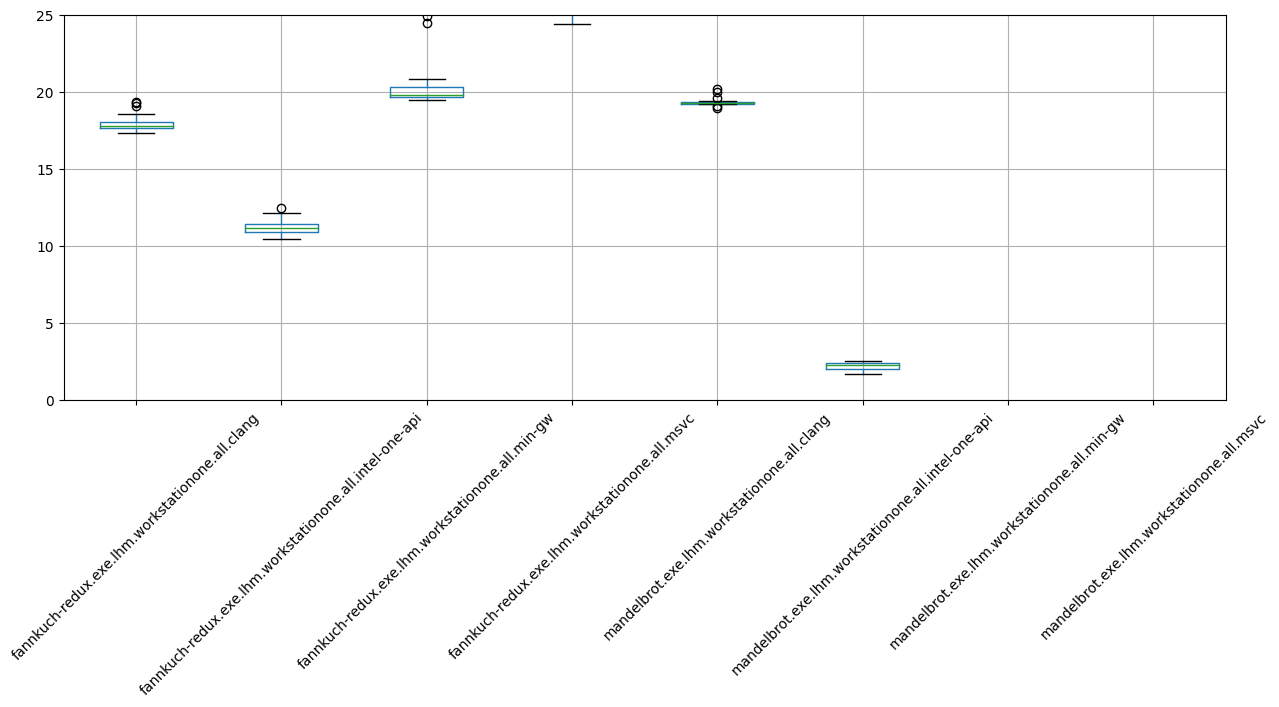

Combined CPU Energy Consumption in Joules


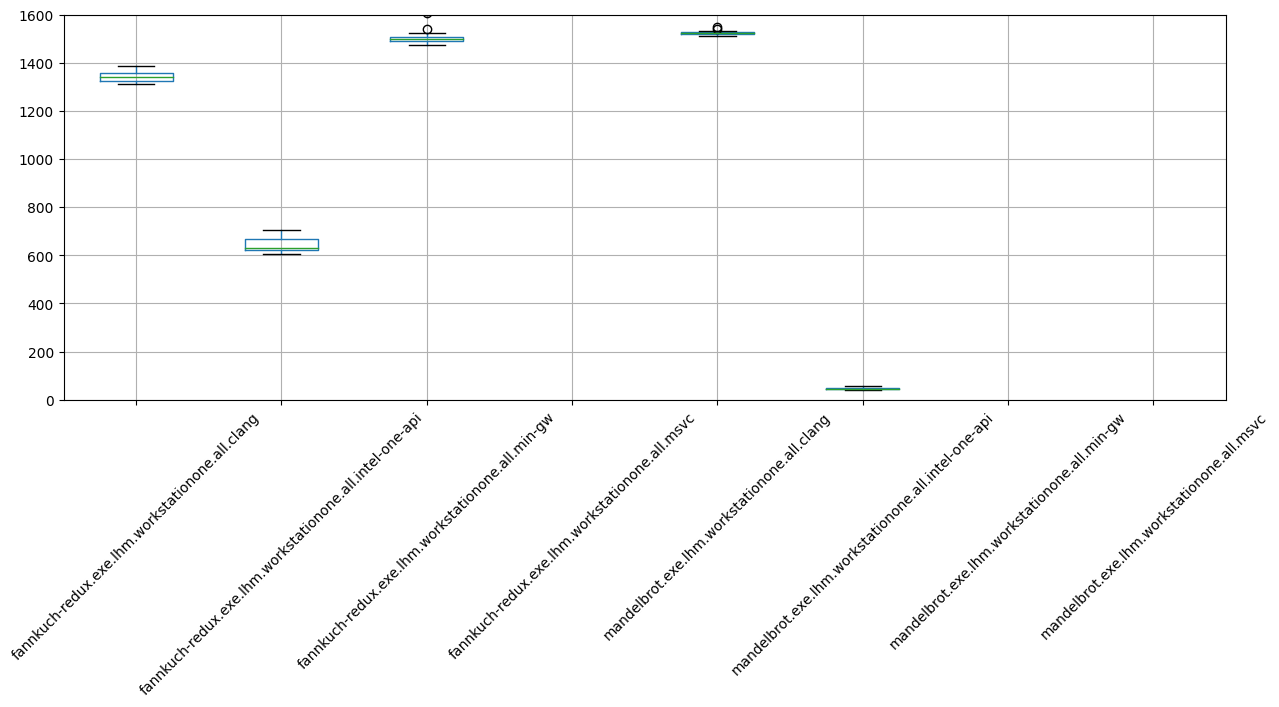

Combined GPU Energy Consumption in Joules


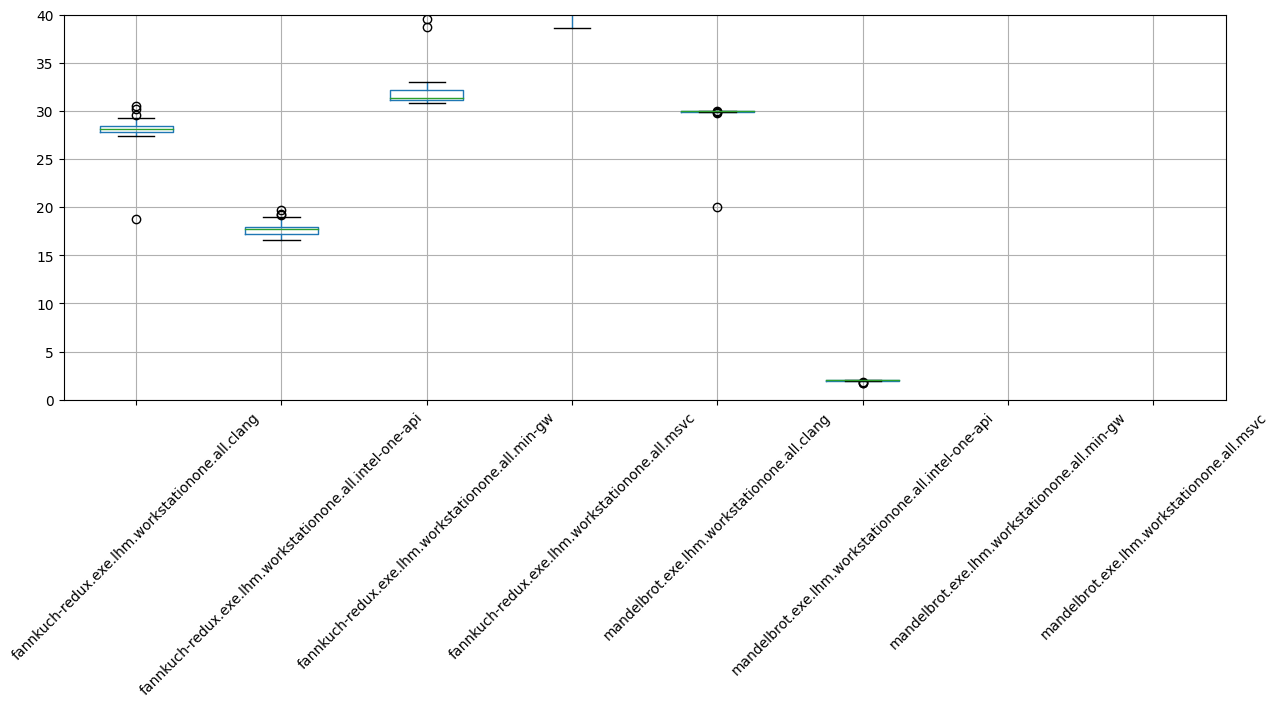

Duration of Test Case


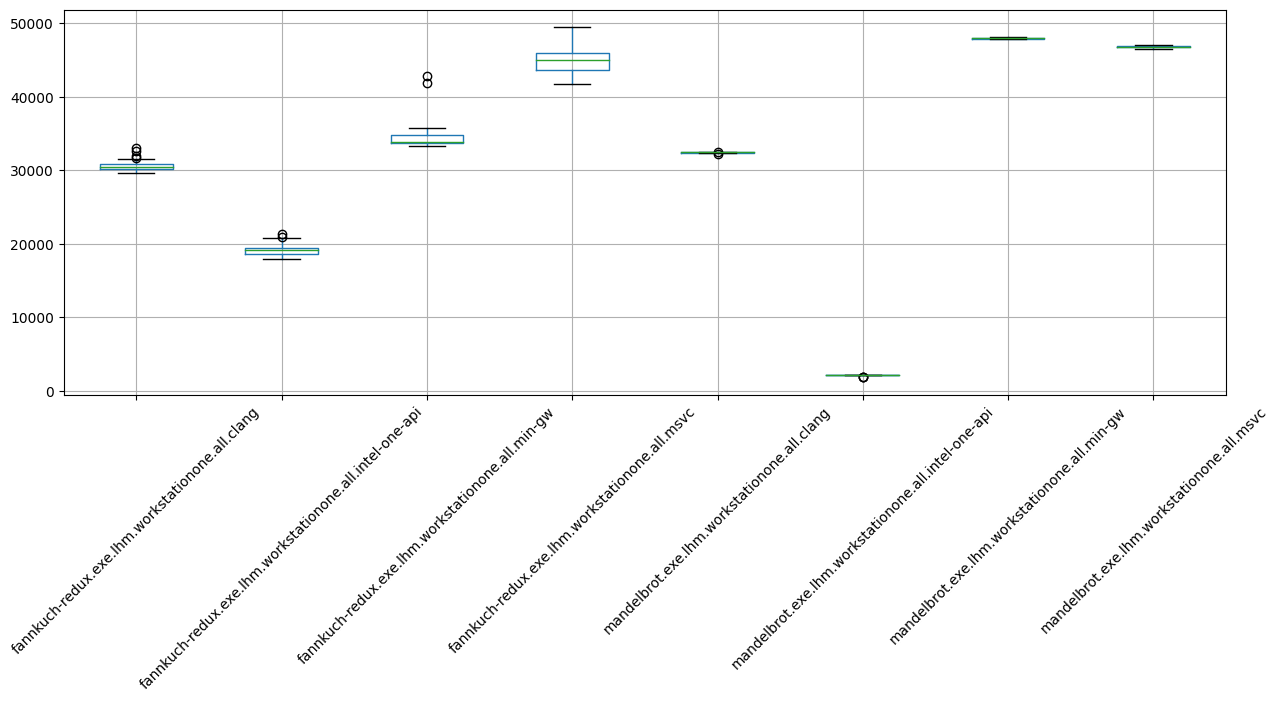

In [127]:
print("Combined DRAM Energy Consumption in Joules")
dram_boxplot = dram_df.boxplot(figsize=(15,5), rot=45)
dram_boxplot.plot()
plot.ylim(0, 25)
plot.show()

print("Combined CPU Energy Consumption in Joules")
cpu_boxplot = cpu_df.boxplot(figsize=(15,5), rot=45)
cpu_boxplot.plot()
cpu_boxplot
plot.ylim(0,1600)
plot.show()

print("Combined GPU Energy Consumption in Joules")
gpu_boxplot = gpu_df.boxplot(figsize=(15,5), rot=45)
gpu_boxplot.plot()
plot.ylim(0,40)
plot.show()

print("Duration of Test Case")
duration_boxplot = duration_df.boxplot(figsize=(15,5), rot=45)
duration_boxplot.plot()
# plot.ylim(0,40)
plot.show()

Dynamic DRAM Energy Consumption in Watts


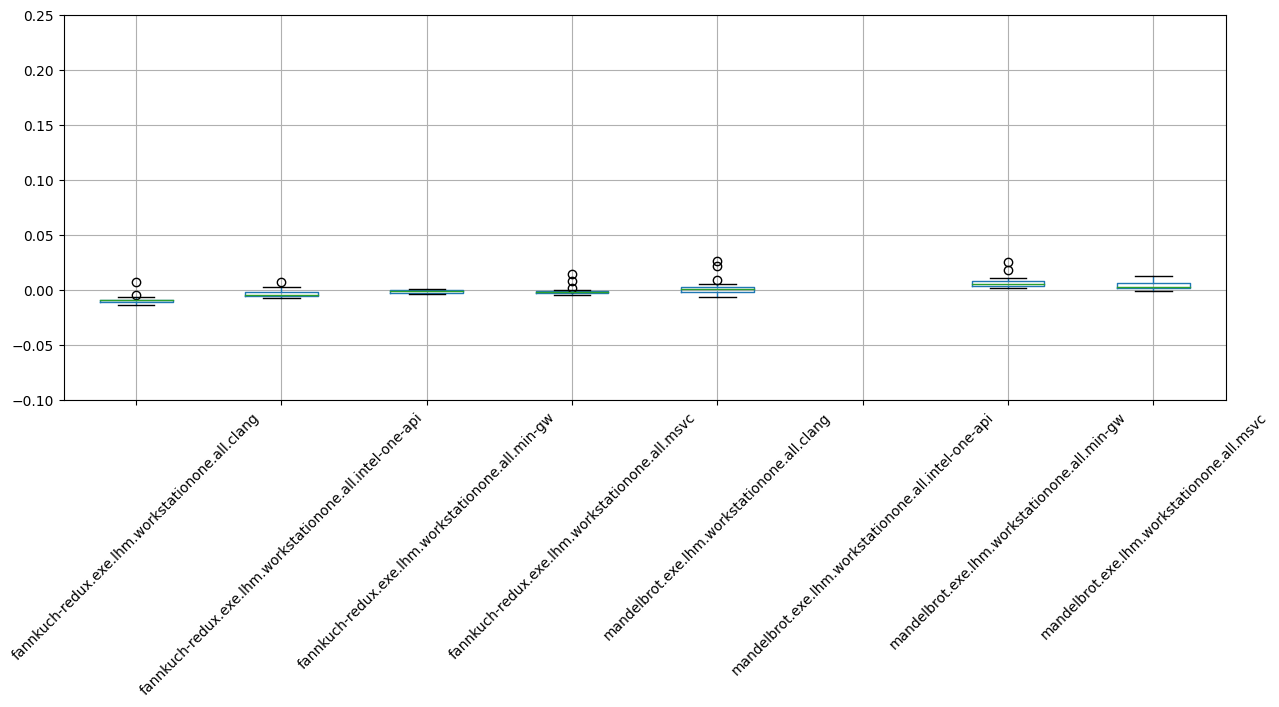

Dynamic CPU Energy Consumption in Watts


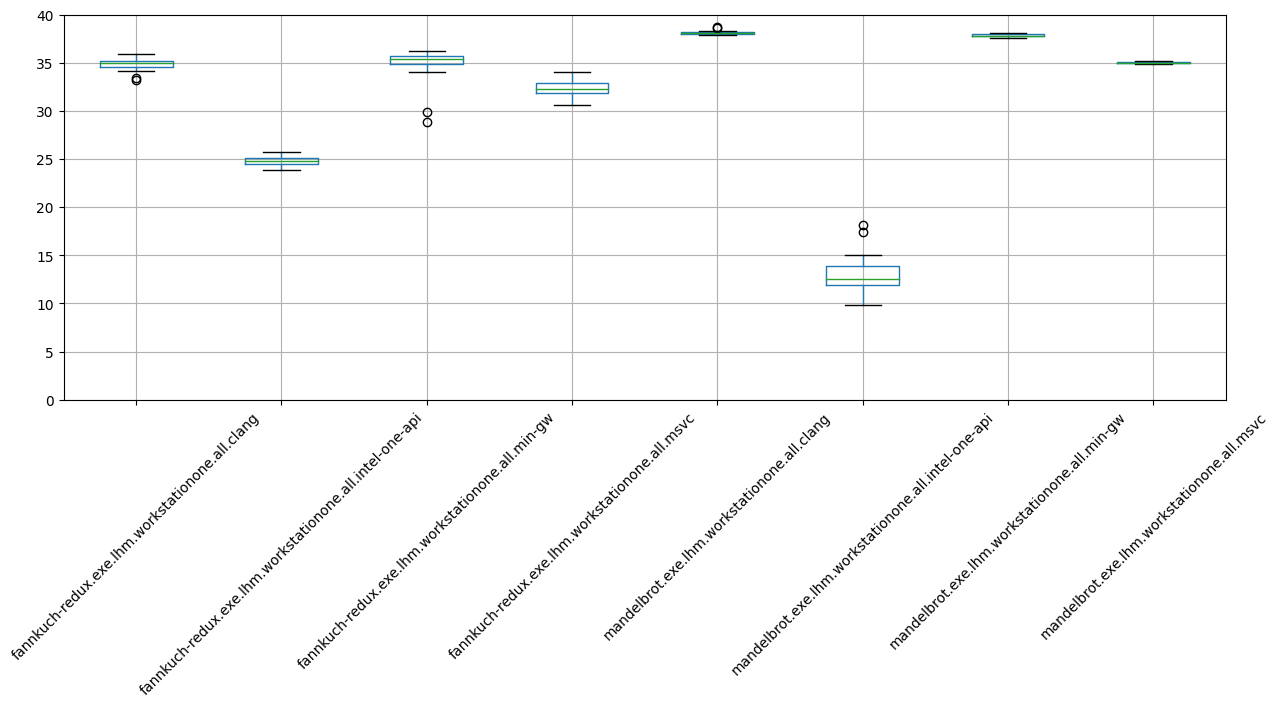

Dynamic GPU Energy Consumption in Watts


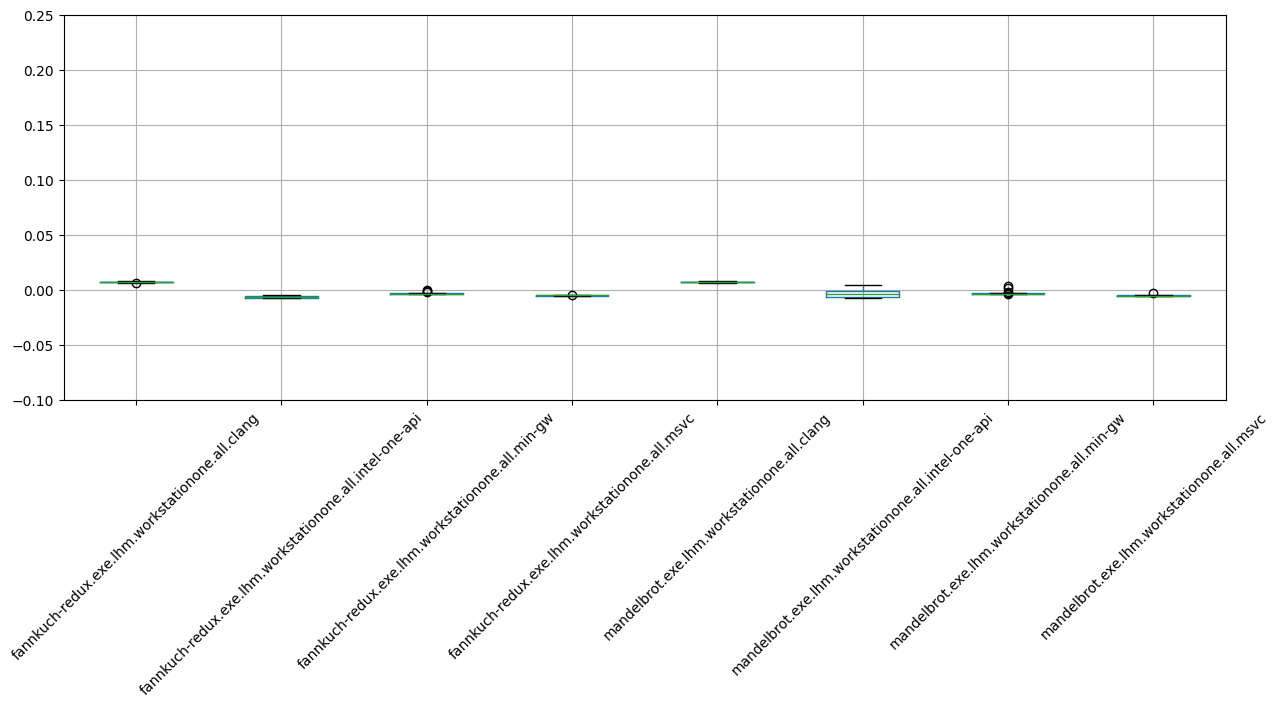

In [128]:
print("Dynamic DRAM Energy Consumption in Watts")
dynamic_dram_boxplot = dram_dynamic_df.boxplot(figsize=(15,5), rot=45)
dynamic_dram_boxplot.plot()
plot.ylim(-0.1, 0.25)
plot.show()

print("Dynamic CPU Energy Consumption in Watts")
dynamic_cpu_boxplot = cpu_dynamic_df.boxplot(figsize=(15,5), rot=45)
dynamic_cpu_boxplot.plot()
plot.ylim(0,40)
plot.show()

print("Dynamic GPU Energy Consumption in Watts")
dynamic_gpu_boxplot = gpu_dynamic_df.boxplot(figsize=(15,5), rot=45)
dynamic_gpu_boxplot.plot()
plot.ylim(-0.1, 0.25)
plot.show()


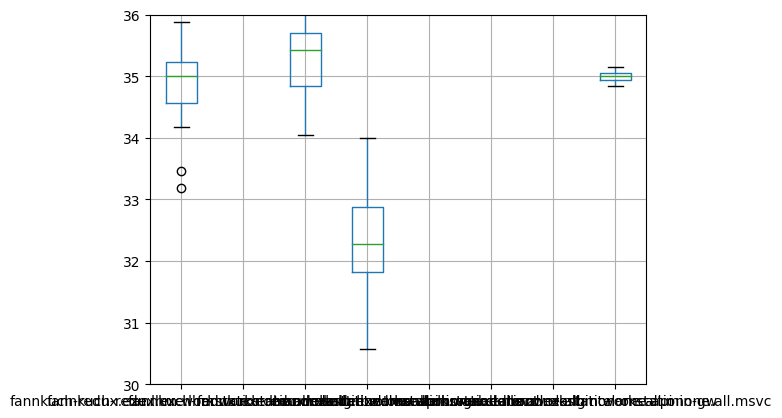

In [129]:
dynamic_cpu_boxplot_test, cpu_dynamic_boxplot_data = cpu_dynamic_df.boxplot(return_type='both')
dynamic_cpu_boxplot_test.plot()
plot.ylim(30,36)
plot.show()

In [130]:
def get_boxplot_template(width, height, xlabel, title, ytick, yticklables, xmin, xmax, box_plots, caption, labels):
    return """\\begin{{figure}}
    \\centering
    \\begin{{tikzpicture}}[]
        \\pgfplotsset{{
            width={0}\\textwidth,
            height={1}\\textheight
        }}
        \\begin{{axis}}[
            xlabel={{{2}}}, 
            title={{{3}}}, 
            ytick={{{4}}},
        yticklabels={{
            {5}
            }},
            xmin={6},xmax={7},
            ]
        
        {8}
        
        \\end{{axis}}
    \\end{{tikzpicture}}
\\caption{{{9}}} \label{{fig:{10}}}
\\end{{figure}}""".format(width, height, xlabel, title, ytick, str(yticklables).replace('[', '').replace(']', '').replace("'", ''), xmin, xmax, box_plots, caption, labels)

In [131]:
box_plot_raw_data = [
    {
        "data" : cpu_dynamic_df,
        "name" : "cpu",
        "data_type" : "dynamic  energy"
    }
]

In [132]:
width = 1
height = 0.5
xmin = 0
xmax = 40
xlabel = "Averate Energy Consumption (Watt)"

In [133]:
def list_to_label(lst):
    if len(lst) == 1:
        return lst[0]
    elif len(lst) == 2:
        return f"{lst[0]} and {lst[1]}"
    else:
        return ", ".join(lst[:-1]) + f" and {lst[-1]}"

In [134]:
str(list(range(2))).replace('[', '').replace(']', '')

'0, 1'

In [135]:
for plot_data in box_plot_raw_data:
    data = plot_data["data"]
    name = plot_data["name"]
    data_type = plot_data["data_type"]
    
    latex_boxes = tex.get_boxes(data)
    
    title = f"The {data_type} consumption of the {name}"
    
    ytick = str(list(range(1, len(list(data.columns))+1))).replace('[', '').replace(']', '')
    
    yticklables = tex.get_ytick_labels(data, used_test_case_names, used_mi_names, used_dut_name, used_allocated_cores)
    
    labels = f"{experiment_number}-{experiment_name}-{'-'.join(used_mi_names)}-{'-'.join(used_test_case_names)}-{'-'.join(used_compilers)}-{'-'.join(used_dut_name)}"
    
    c_test_cases = list_to_label(used_test_case_names)
    c_compiler = list_to_label(used_compilers)
    c_duts = list_to_label(used_dut_name)
    c_measuring_instrument = list_to_label(used_mi_names)
    
    c_test_cases = c_test_cases.replace(".exe", "")
    
    caption = f"{data_type} measurements on the {name}, measured by {c_measuring_instrument} on {c_duts}, for test cases {c_test_cases} compiled on {c_compiler}"
    
    latex_box_plot = get_boxplot_template(width, height, xlabel, title, ytick, yticklables, xmin, xmax, latex_boxes, caption, labels)

box_plot_path = f"{experiment_number}/{experiment_name}/{'-'.join(used_mi_names)}/{'-'.join(used_test_case_names)}/{'-'.join(used_dut_name)}/{'-'.join(used_compilers)}"
box_plot_file_name = f"file.tex"

path_util.write_to_path(box_plot_path, box_plot_file_name, latex_box_plot)

In [136]:
cpu_dynamic_df

,fannkuch-redux.exe.lhm.workstationone.all.clang,fannkuch-redux.exe.lhm.workstationone.all.intel-one-api,fannkuch-redux.exe.lhm.workstationone.all.min-gw,fannkuch-redux.exe.lhm.workstationone.all.msvc,mandelbrot.exe.lhm.workstationone.all.clang,mandelbrot.exe.lhm.workstationone.all.intel-one-api,mandelbrot.exe.lhm.workstationone.all.min-gw,mandelbrot.exe.lhm.workstationone.all.msvc
0,35.335123,25.064393,35.432187,32.185614,38.646489,12.814956,37.797780,35.136511
1,35.599181,24.431741,35.929209,32.157894,38.244744,14.995118,37.970250,35.111961
2,35.598978,23.961102,35.358151,32.866292,38.075326,14.674224,37.789176,34.954633
3,35.100818,24.674108,35.968419,31.555777,38.191824,11.610578,37.986902,34.892911
4,35.184549,25.076279,35.701169,32.271070,38.277735,12.502020,37.682715,35.051241
5,34.325376,24.251672,29.925890,33.999224,38.139864,13.615090,37.964275,34.875769
6,33.183222,25.691610,35.569292,33.265967,38.155482,10.107667,38.100851,34.841463
7,35.885446,24.733651,36.174218,33.067886,38.091536,12.307981,38.029858,35.027332
8,35.230682,24.904378,35.230408,32.765107,38.020191,11.367838,37.890047,35.009563
9,34.833982,24.730423,34.841664,31.368278,37.963149,13.893028,37.877374,35.087484


```latex
\begin{figure}
    \centering
    \begin{tikzpicture}[]
        \pgfplotsset{
            width=WIDTH\textwidth, %% 0.8
            height=WIDHT\textheight %% 0.14
        }
        \begin{axis}[
            xlabel={XLABEL}, 
            title={TITLE}, 
            ytick={YTICK}, %% 1,2
        yticklabels={
            LABELS %% L1, L2, 
            },
            xmin=XMIN,xmax=XMAX,
            ]
        
        \addplot+ [boxplot prepared={
        lower whisker=LOW_WHISKER,
        lower quartile=LOW_QUANTILE,
        median=MEDIAN,
        upper quartile=UPPER_QUANTILE,
        upper whisker=UPPER_WHISKER
        }, color = red
        ] coordinates{COORDINATES}; %% (0,4.832228)(0,5.513942)
        
        \end{axis}
    \end{tikzpicture}
\caption{CAPTION} \label{fig:LABEL}
\end{figure}
```